# Natural Language Processing Project
# Retreival Augmented Generation from Scratch
## Submitted by: Sarim Aeyzaz (i21-0328)



-----------

## Project Pipeline

![title](pipeline.png)

## Checking Current GPU

In [1]:
!nvidia-smi

Sun May 12 09:33:29 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.78                 Driver Version: 551.78         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1660 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   49C    P8              8W /   80W |     880MiB /   6144MiB |     25%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Importing Libraries

In [2]:
import os
import re
import fitz
import torch
import shutil
import requests
import numpy as np
import pandas as pd
from random import sample                
import matplotlib.pyplot as plt

from spacy.lang.en import English
from tqdm.notebook import tqdm_notebook as tqdm
from sentence_transformers import SentenceTransformer

from langchain.schema.document import Document
from langchain.prompts import ChatPromptTemplate
from langchain.embeddings.base import Embeddings
from langchain.vectorstores.chroma import Chroma
from langchain_community.llms.ollama import Ollama

## Wrapper Sentence Transformer Class for Embeddings

In [3]:
# Wrapper-like class to make hugging face sentence transformers compatible with langchain's chroma database's embedding function style

class SentenceTransformerEmbeddings(Embeddings):
    def __init__(self, model_name):
        self.model = SentenceTransformer(model_name)

    def embed_documents(self, documents):
        return [self.model.encode(d).tolist() for d in documents]

    def embed_query(self, query):
        return self.model.encode([query])[0].tolist()

## RAG Class

In [4]:
class RAG():
    def __init__(self, embedding_model_name = "all-MiniLM-L12-v2", CHROMA_STORE_PATH = "chroma"):
        '''
        embedding_model_name = Name of a model from huggingface, you must have ollama installed and pull this model name
        over there too. After that you need to run ollama serve

        chroma_store_path = Path to store chroma vector db
        '''

        # For storing text-related information of different PDFs
        self.__pdf_paths_and_starting_pages = set()
        self.__pages_and_texts = []
        self.__pages_and_chunks = []

        # Keeps track of PDFs
        self.__books_traversed = []

        # For sentence tokenizer
        self.__nlp = English()
        self.__nlp.add_pipe("sentencizer")

        # Loads the embedding model. Default is all-MiniLM-L12-v2 because right now it's one of the best and ~5x faster than the top option
        # To check current sentence transformer leaderboards: https://www.sbert.net/docs/pretrained_models.html
        self.__embedding_model = SentenceTransformerEmbeddings(embedding_model_name)

        # Variables to load chroma vector database (also uses the embedding model up above)
        self.__CHROMA_STORE = CHROMA_STORE_PATH
        self.__db = Chroma(persist_directory=CHROMA_STORE_PATH, embedding_function=self.__embedding_model)
        
        # Stores current decoder transformer
        self.__model = None


    
    def open_and_read_pdfs(self, pdf_paths_and_starting_pages):
        '''
        pdf_paths_and_starting_pages = List of tuples containing pdf paths and an integers indicating the starting page of each pdf
        '''

        # Remove non-persistent data
        self.__pages_and_texts = []
        
        # Maintain a list of books and their starting numbers, regardless if the user changes it
        self.__pdf_paths_and_starting_pages = set(pdf_paths_and_starting_pages) | self.__pdf_paths_and_starting_pages

        # Iterate over every book
        for pdf_path, pdf_starting_page in pdf_paths_and_starting_pages:

            # Skip a book if it is already read
            if pdf_path in self.__books_traversed:
                print(f"Book ({pdf_path}) has already been read. Skipping...")
                continue

            # Open book
            doc = fitz.open(pdf_path)

            # Iterate books pages
            for page_number, page in enumerate(tqdm(doc)):

                # Skip pages before the starting page given by user
                actual_page_number = page_number - pdf_starting_page
                if actual_page_number < 0:
                    continue

                # Convert page information into a dictionary
                text = page.get_text()
                text = text.replace("\n", " ").strip()
                self.__pages_and_texts.append({
                                             "source": pdf_path,
                                             "page_number": actual_page_number,
                                             "page_char_count": len(text),
                                             "page_word_count": len(text.split(" ")),
                                             "page_sentence_count_raw": len(text.split(". ")),
                                             "page_token_count": len(text) / 4, # 1 token ~4 characters (https://platform.openai.com/tokenizer)
                                             "text": text
                                            })
            # Add book to traversed list
            self.__books_traversed.append(pdf_path)
        
        return self.__pages_and_texts  


    
    def convert_to_pages_and_chunks(self, sentence_chunk_size = 10, chunk_token_threshold = 30):
        '''
        sentence_chunk_size = Sentences per chunk
        
        chunk_token_threshold = Minimum number of estimated tokens each chunk should have
        '''

        # Remove non-persistent data
        self.__pages_and_chunks = []

        # Check if pdf have been read or not
        if len(self.__pages_and_texts) == 0:
            print("Cannot proceed with current function as pages_and_texts is empty, please run the prerequisite function (open_and_read_pdfs). Exiting...")
            return -1
        
        # Convert text to list of sentences + store metadata
        for item in tqdm(self.__pages_and_texts):
            item["sentences"] = list(self.__nlp(item["text"]).sents)
            item["sentences"] = [str(sentence) for sentence in item["sentences"]]
            item["page_sentence_count"] = len(item["sentences"])
            item["sentence_chunks"] = [item["sentences"][i:i+sentence_chunk_size] for i in range(0, len(item["sentences"]), sentence_chunk_size)]
            item["num_chunks"] = len(item["sentence_chunks"])
    
        # Reformat w.r.t chunks
        for item in tqdm(self.__pages_and_texts):
            for chunk_id, sentence_chunk in enumerate(item["sentence_chunks"]):

                # Create and store ID related information
                chunk_dict = {}
                chunk_dict["id"] = item["source"] + ":" + str(item["page_number"]) + ":" + str(chunk_id)
                chunk_dict["source"] = item["source"]
                chunk_dict["page_number"] = item["page_number"]
                
                # Join sentences into paragraph
                joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()   # Generalist reformat to remove excessive spaces
                joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo 

                # Store sentence chunk and other information
                chunk_dict["sentence_chunk"] = joined_sentence_chunk
                chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
                chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
                chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token ~4 characters (https://platform.openai.com/tokenizer)

                # If chunk doesn't meet a certain number of token threshold, skip it. (Not enough context inside that chunk, might even backfire)
                if chunk_dict["chunk_token_count"] < chunk_token_threshold:
                    continue

                # Store chunk
                self.__pages_and_chunks.append(chunk_dict)

        print(f"Total {len(self.__pages_and_chunks)} chunks created from {len(self.__pages_and_texts)} page texts")
    
        return self.__pages_and_chunks


    
    def display_chunk_metrics(self):
        df = pd.DataFrame(self.__pages_and_chunks)
        return df.describe()



    def return_chroma_db(self):
        return self.__db

    

    def add_to_chroma(self, batch_size = 1000):
        '''
        batch_size = Maximum number to keep in a temporary variable before inserting into vector database. Do not go over 5.6k
        '''

        # Get current IDs stored in the vector database
        existing_items = self.__db.get(include=[])  # IDs are always included by default ([])
        existing_ids = set(existing_items["ids"])   # There shouldn't be any duplicates based on my new ID logic but keeping this here just incase

        # Calculating number of remaining chunks to add (from self.__pages_and_chunks)
        print(f"Number of existing documents in DB: {len(existing_ids)}")
        remaining = len(self.__pages_and_chunks) - len(existing_ids)
        print(f"Attempting to add {remaining} chunks into chroma...")
    
        # Only add documents that don't exist in the DB.
        new_chunks = []
        for chunk in self.__pages_and_chunks:

            # If the chunk isn't already in the database
            if chunk["id"] not in existing_ids:

                # Convert chunk information into langchain document
                new_document = Document(page_content = chunk["sentence_chunk"],
                                        metadata = {"id" : chunk["id"],
                                                    "source" : chunk["source"],
                                                    "page_number": chunk["page_number"],
                                                    "chunk_char_count": chunk["chunk_char_count"],
                                                    "chunk_word_count": chunk["chunk_word_count"],
                                                    "chunk_token_count": chunk["chunk_token_count"]})
                # Add document to list
                new_chunks.append(new_document)
                
                # Add documents in batches and add each batch to the chroma vector store (Since there is a max batch limit of ~5600)
                if len(new_chunks) >= batch_size:
                    print(f"Batch full! Adding new documents: {len(new_chunks)}")
                    new_chunk_ids = [chunk.metadata["id"] for chunk in new_chunks]
                    self.__db.add_documents(new_chunks, ids=new_chunk_ids)
                    new_chunks = []  # Clear the batch after inserting

        # Add any remaining documents after the loop
        if len(new_chunks):
            print(f"Adding remaining documents: {len(new_chunks)}")
            new_chunk_ids = [chunk.metadata["id"] for chunk in new_chunks]
            self.__db.add_documents(new_chunks, ids=new_chunk_ids)
        else:
            print("No new documents to add")
        print("Done!")

    
    def clear_database(self, batch_size = 1000):

        # You never know...
        confirmation = input("Are you sure you want to delete the entire database? (y/N): ")
        
        if confirmation.lower() == "y":

            # Get IDs of all records currently in the database
            print("Deleting stored database.")
            existing_items = self.__db.get(include=[])  # IDs are always included by default
            existing_ids = existing_items["ids"]
            print(f"Total items to delete: {len(existing_ids)}")
  
            # Delete items batch-wise here too (because of the same ~5600 batch size limit)
            for i in range(0, len(existing_ids), batch_size):
                self.__db.delete(ids=existing_ids[i:i+batch_size])
            print("Deletion done.")
        else:
            print("Deletion cancelled.")
        
    def load_model(self, model_name = "phi3"):

        # Loading model, requires you to install ollama first and pull whatever model you wish to use locally
        # I chose phi3 since it's a very small model (4B parameters) and is good enough for Question & Answering task
        # You can check current top LLM models over here, install it locally and run it
        # LLM Leaderboards: https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard
        self.__model =  Ollama(model=model_name)

    def query_rag(self, query_text, k = 5, display_most_relevant_source = False, PROMPT_TEMPLATE = None):

        # This is the basic phi3 template, you can look it up here (https://huggingface.co/docs/transformers/main/en/model_doc/phi3)
        if PROMPT_TEMPLATE is None:
            PROMPT_TEMPLATE = """
            <|user|> {context} <|end|>
            
            <|user|> Use the above context to help amplify in answering this question: {question} <|end|>
            """

        # Embed query vector & do similarity search
        results = self.__db.similarity_search_with_score(query_text, k=k)

        # Join context with prompt
        context_text = "\n\n---\n\n".join([doc.page_content for doc, _score in results])
    
        # Format prompt according to whatever the user gave in parameters of the default phi3 prompt
        prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
        prompt = prompt_template.format(context=context_text, question=query_text)
        print(prompt)

        # If no model was loaded, load the phi3 model
        if self.__model == None:
            self.load_model()

        # Generate Response
        response_text = self.__model.invoke(prompt)

        # Output sources
        sources = [doc.metadata.get("id", None) for doc, _score in results]
        formatted_response = f"\n\n\nResponse: {response_text}\n\nSources: {sources}\n\n\n"
        print(formatted_response)

        # If you need to display the page from which the chunk belonged
        if display_most_relevant_source:
            for source in sources:

                # Extract relevant information & open the pdf
                top_score_path, top_score_page_num, top_score_chunk_num = source.split(":")
                doc = fitz.open(top_score_path)

                # Find starting number of pdf from a list we maintained wayyyy earlier
                starting_num = 0
                for pdf_path, num in self.__pdf_paths_and_starting_pages:
                    if pdf_path == top_score_path:
                      starting_num = num 

                # Load the exact page and convert it to a pixmap
                page = doc.load_page(int(top_score_page_num) + int(starting_num))
                img = page.get_pixmap(dpi=300)
                doc.close()

                # Convert pixmap to image and show it
                img_array = np.frombuffer(img.samples_mv, dtype=np.uint8).reshape((img.h, img.w, img.n))
                plt.figure(figsize=(13, 10))
                plt.imshow(img_array)
                plt.title(f"Query: '{query_text}' | Book ({top_score_path}) | Relevant page ({int(top_score_page_num)+1}):")
                plt.axis('off') # Turn off axis
                plt.show()

## RAG Initialization

In [5]:
rag = RAG()

# Very recent future warning bug, should be fixed in a few weeks hopefully (https://github.com/huggingface/huggingface_hub/issues/2275)

C:\Users\hoxto\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\hoxto\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Clearing Database (if needed)

In [25]:
rag.clear_database()

Are you sure you want to delete the entire database? (y/N):  n


Deletion cancelled.


## Parsing PDFs into our RAG

In [6]:
# I manually chose the starting page of each book, it's honestly up to you on which number to choose to begin reading the book from 
book_info = [("data/cnet-book.pdf", 11), ("data/dip-book.pdf", 18), ("data/nlp-book.pdf", 0)]

pages_and_texts = rag.open_and_read_pdfs(book_info)

  0%|          | 0/775 [00:00<?, ?it/s]

  0%|          | 0/1022 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

In [7]:
display(sample(pages_and_texts, 1))

[{'source': 'data/nlp-book.pdf',
  'page_number': 575,
  'page_char_count': 1616,
  'page_word_count': 260,
  'page_sentence_count_raw': 13,
  'page_token_count': 404.0,
  'text': 'DRAFT Section 16.3. Feature Structures in the Grammar 15 general phenomenon in constraint-based grammars. Speciﬁcally, the features for most grammatical categories are copied from one of the children to the parent. The child that provides the features is called the head of the phrase, and the features HEAD OF THE PHRASE copied are referred to as head features. HEAD FEATURES This idea of heads, ﬁrst introduced in Sec. ??, plays an important role in constraint-based grammars. Consider the following three rules from the last sec- tion. VP →Verb NP ⟨VP AGREEMENT⟩= ⟨Verb AGREEMENT⟩ NP →Det Nominal ⟨Det AGREEMENT⟩= ⟨Nominal AGREEMENT⟩ ⟨NP AGREEMENT⟩= ⟨Nominal AGREEMENT⟩ Nominal →Noun ⟨Nominal AGREEMENT⟩= ⟨Noun AGREEMENT⟩ In each of these rules, the constituent providing the agreement feature struc- ture to its par

## Convert Texts of pages to Chunks

In [8]:
# Ideally, this shouldn't be too large otherwise the Sentence Tranformer will not read the sentences that go beyond its sequence
# length, the default sentence transformer I chose only has a max sequence length of 256. If each chunk has 1200 character, it'll have ~400 tokens
# and so, 144 tokens are dropped off since the sentence transformer's context limit was reached.

# I'll choose this value arbitrarily and see what my average and 75% of the data is looking like in terms of token count
sentence_chunk_size = 6

# This sets a threshold for a minimum number of tokens per chunk. The general idea is that low-token chunks will not provide enough context when
# They are retreived so they're just getting dropped out for now
chunk_token_threshold = 10

# If you change the above parameters, you need to reinstantiate the model & run the above cells again (yes, i know)
pages_and_chunks = rag.convert_to_pages_and_chunks(sentence_chunk_size, chunk_token_threshold)

  0%|          | 0/2812 [00:00<?, ?it/s]

  0%|          | 0/2812 [00:00<?, ?it/s]

Total 11732 chunks created from 2812 page texts


In [9]:
display(sample(pages_and_chunks, 1))

[{'id': 'data/dip-book.pdf:598:1',
  'source': 'data/dip-book.pdf',
  'page_number': 598,
  'sentence_chunk': 'The latter allow useful analysis properties, like the number of vanishing moments (see Section 7.10), to be incor- porated into the decomposition ﬁlters, while important synthesis properties, like smoothness of reconstruction, are built into the reconstruction ﬁlters. EXAMPLE 8.25 : Wavelet bases in wavelet coding. Figure 8.43 contains four discrete wavelet transforms of Fig.8.9(a). Haar wavelets, the simplest and only discontinuous wavelets considered in this example, were used as the expansion or basis functions in Fig.8.43(a).',
  'chunk_char_count': 535,
  'chunk_word_count': 76,
  'chunk_token_count': 133.75}]

## Checking Chunk Description (mainly average token count)

In [10]:
rag.display_chunk_metrics()

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,11732.000000,11732.000000,11732.000000,11732.000000
mean,495.158370,588.405131,101.255540,147.101283
std,293.390416,309.737542,58.703111,77.434385
min,0.000000,40.000000,3.000000,10.000000
25%,245.000000,332.000000,55.000000,83.000000
50%,487.500000,581.500000,99.000000,145.375000
75%,732.000000,790.000000,134.000000,197.500000
max,1043.000000,2672.000000,619.000000,668.000000


### 75% of the data has tokens which are much lower than the 256 context limit, i'll keep the above sentence_chunk_size at that value then

## Adding Chunks & their embeddings to Chroma Vector Database

In [31]:
rag.add_to_chroma()

Number of existing documents in DB: 11732
Attempting to add 0 chunks into chroma...
No new documents to add
Done!


## Querying Normal phi3

In [34]:
def query_simple(query_text):

    # Load model & generate response
    model = Ollama(model="phi3")
    response_text = model.invoke(query_text)
    print(response_text)

In [35]:
query_simple("Explain SMTP")

SMTP stands for Simple Mail Transfer Protocol, which is an internet standard communication protocol used for sending electronic mail (email) over the Internet. It is a text-based protocol that uses TCP/IP networks to transmit messages between email servers, allowing emails to be sent from one server to another until they reach their final destination.

Here are some key aspects of SMTP:

1. Communication channel: SMTP operates on a client-server model where the client (email sending user's computer or application) sends messages to the server, which then forwards them through other servers using SMTP until they reach their intended recipient's email server.

2. Protocol version: The current official version of SMTP is 5. The initial version was created in 1980 and has undergone several updates over the years to improve functionality, security, and performance. However, the protocol continues to be backward-compatible with older versions.

3. Process flow: When a user sends an email usi

## Query Rag

In [36]:
rag.query_rag("Explain SMTP", k = 3)

Human: 
            <|user|> 2.3 • ELECTRONIC MAIL IN THE INTERNET   119 particular, if Bob’s mail server is down, the message remains in Alice’s mail server and waits for a new attempt—the message does not get placed in some intermediate mail server. Let’s now take a closer look at how SMTP transfers a message from a send- ing mail server to a receiving mail server. We will see that the SMTP proto- col has many similarities with protocols that are used for face-to-face human interaction. First, the client SMTP (running on the sending mail server host) has TCP establish a connection to port 25 at the server SMTP (running on the receiv- ing mail server host). If the server is down, the client tries again later. Once this connection is established, the server and client perform some application- layer handshaking—just as humans often introduce themselves before trans- ferring information from one to another, SMTP clients and servers introduce themselves before transferring information.



## Query Rag and display source pages

Human: 
            <|user|> 2.3 • ELECTRONIC MAIL IN THE INTERNET   119 particular, if Bob’s mail server is down, the message remains in Alice’s mail server and waits for a new attempt—the message does not get placed in some intermediate mail server. Let’s now take a closer look at how SMTP transfers a message from a send- ing mail server to a receiving mail server. We will see that the SMTP proto- col has many similarities with protocols that are used for face-to-face human interaction. First, the client SMTP (running on the sending mail server host) has TCP establish a connection to port 25 at the server SMTP (running on the receiv- ing mail server host). If the server is down, the client tries again later. Once this connection is established, the server and client perform some application- layer handshaking—just as humans often introduce themselves before trans- ferring information from one to another, SMTP clients and servers introduce themselves before transferring information.



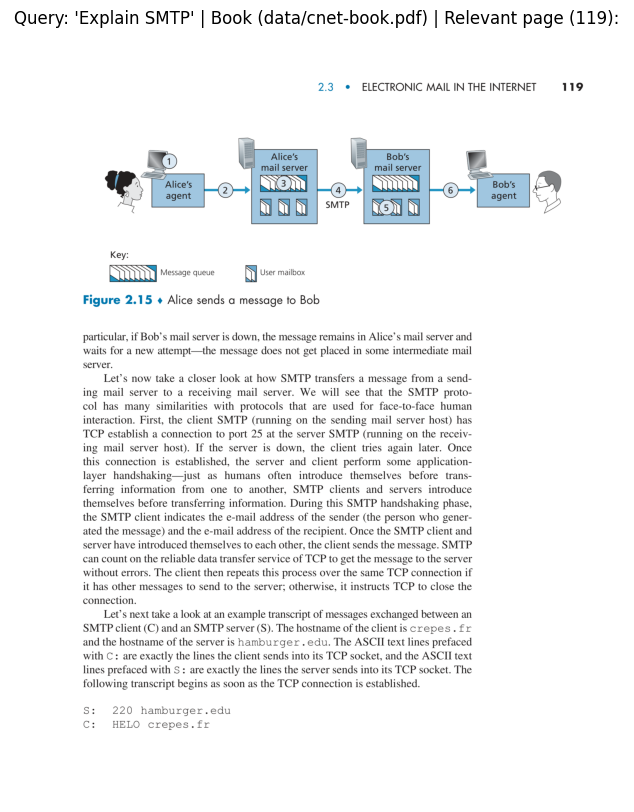

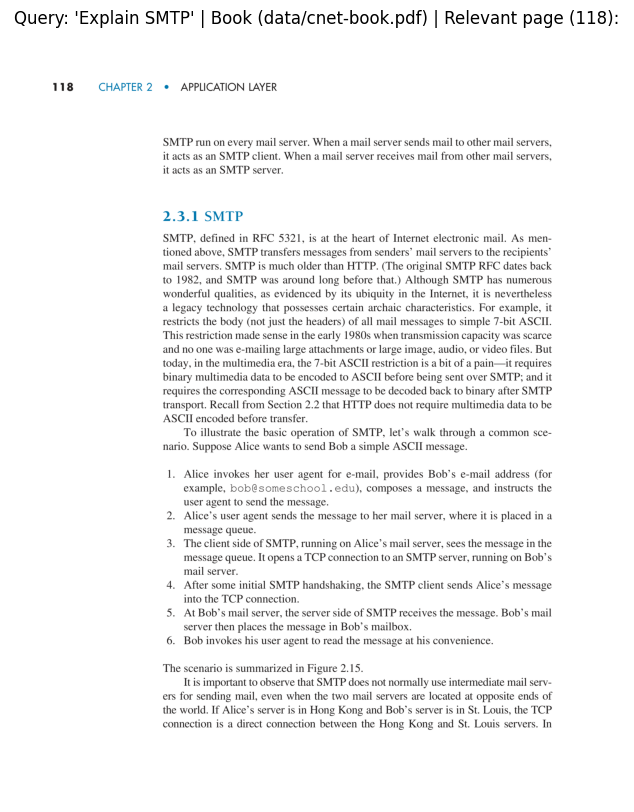

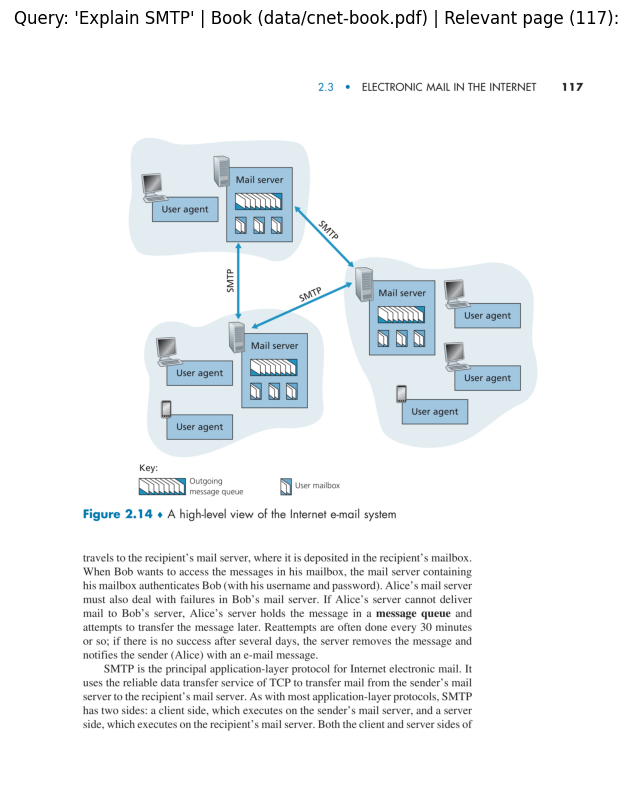

In [37]:
rag.query_rag("Explain SMTP", k = 3, display_most_relevant_source = True)

-----------

## Visually checking embeddings of query and k score similarity results
### (Technical outputs which got removed when I made everything a class, honestly don't know where to put this)

In [38]:
db = rag.return_chroma_db()
embedding_model = SentenceTransformer("all-MiniLM-L12-v2")

C:\Users\hoxto\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [44]:
query = "Exlpain SMTP"

embedding_query = embedding_model.encode(query)
print("Showing query embedding \n\n")
print(embedding_query)

Showing query embedding 


[-1.28876092e-02 -9.14998073e-03 -1.87426209e-02 -1.04506658e-02
  1.65366735e-02 -9.39716622e-02  4.96513806e-02  1.53380679e-02
  1.35116167e-02 -7.27406517e-02 -1.65107334e-03  4.72807661e-02
 -3.68698239e-02 -1.01968069e-02  7.27473944e-02  5.92396446e-02
  2.97704078e-02 -4.83616032e-02  5.75239025e-02 -6.04295470e-02
  4.90096956e-02 -4.90334928e-02 -3.82723175e-02 -5.20092621e-02
 -6.97054490e-02  2.95057753e-03 -2.98974942e-02 -4.33794260e-02
 -6.13372661e-02 -3.50134075e-02  5.87326549e-02  7.44802877e-02
 -5.63391671e-02 -2.33923756e-02 -1.04836822e-02  4.51432690e-02
  1.15038427e-02 -2.13826317e-02 -2.66092792e-02 -1.19178314e-02
  3.31538320e-02  3.95752154e-02 -1.98977627e-03 -6.23680986e-02
  2.48178132e-02 -3.37580591e-02  2.65479740e-02  4.52706777e-02
 -2.57177670e-02 -4.19585072e-02  7.40618631e-02 -7.83858895e-02
  7.82191381e-02  1.13568857e-01  1.35798445e-02 -2.96233650e-02
  1.14472080e-02 -2.69284938e-03 -3.66673875e-03 -7.58463815e-0

In [45]:
results = db.similarity_search_with_score(query, k = 5)
results

[(Document(page_content='118   CHAPTER 2 • APPLICATION LAYER SMTP run on every mail server. When a mail server sends mail to other mail servers, it acts as an SMTP client. When a mail server receives mail from other mail servers, it acts as an SMTP server.2.3.1 SMTP SMTP, defined in RFC 5321, is at the heart of Internet electronic mail. As men- tioned above, SMTP transfers messages from senders’ mail servers to the recipients’ mail servers. SMTP is much older than HTTP. (', metadata={'chunk_char_count': 451, 'chunk_token_count': 112.75, 'chunk_word_count': 83, 'id': 'data/cnet-book.pdf:117:0', 'page_number': 117, 'source': 'data/cnet-book.pdf'}),
  0.774608314037323),
 (Document(page_content='Then issue the SMTP commands HELO, MAIL FROM, RCPT TO, DATA, CRLF. CRLF, and QUIT at the appropriate times. It is also highly recommended that you do Programming Assignment 3 at the end of this chapter. In that assign- ment, you’ll build a simple user agent that implements the client side of SMTP.

In [46]:
result_ids = [result[0].metadata["id"] for result in results]
result_ids

['data/cnet-book.pdf:117:0',
 'data/cnet-book.pdf:119:3',
 'data/cnet-book.pdf:116:1',
 'data/cnet-book.pdf:118:0',
 'data/cnet-book.pdf:119:2']

In [47]:
# Showing embedding of top result
result_id = result_ids[0]
db._collection.get(ids=result_id, include=['embeddings', 'metadatas', 'documents'])

{'ids': ['data/cnet-book.pdf:117:0'],
 'embeddings': [[0.0027104911860078573,
   0.018000327050685883,
   -0.014270982705056667,
   -0.06120149418711662,
   0.00902489386498928,
   0.006333269644528627,
   0.022120678797364235,
   -0.031188322231173515,
   -0.02376914769411087,
   -0.0033378854859620333,
   -0.018811190500855446,
   0.07198848575353622,
   -0.024223722517490387,
   0.05344868823885918,
   0.0961625799536705,
   0.06921952217817307,
   0.05829542875289917,
   -0.046136338263750076,
   0.04340718686580658,
   -0.029618797823786736,
   0.024477558210492134,
   -0.017151474952697754,
   -0.06678490340709686,
   0.004344548098742962,
   -0.057917386293411255,
   -0.06191841885447502,
   -0.05862224102020264,
   -0.08386613428592682,
   -0.11480310559272766,
   -0.03872424736618996,
   -0.0016362370224669576,
   0.017241220921278,
   -0.03836344555020332,
   0.05595797300338745,
   -0.024723345413804054,
   0.04529343917965889,
   -0.060685932636260986,
   -0.063173048198223

# Thank you!